In [1]:
import altair as alt
import pandas as pd
import json
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
servers = ["rust", "python", "rust_on_python"]
concurrencies = [2, 4, 8, 16, 32, 64, 128, 256, 1024, 2048, 4096]

In [3]:
def error_rate(status_distribution):
    total = sum([v for v in status_distribution.values()])
    success = [v for (k, v) in status_distribution.items() if k == "OK"][0]
    return (1 - (success / total)) * 100

In [4]:
measurements = []
for server in servers:
    for concurrency in concurrencies:
        filename = f"{server}_{concurrency}.json"
        with open(f"../grpc-benchmark-outputs/{filename}") as f:
            raw_measurement = json.load(f)
            
        measurement = {"server": server, "concurrency": concurrency}
        measurement['requests_per_second'] = raw_measurement['rps']
        measurement['error_rate'] = error_rate(raw_measurement['statusCodeDistribution'])
        for latency in raw_measurement['latencyDistribution']:
            key = f"p{latency['percentage']}"
            # Convert to milliseconds
            measurement[key] = latency['latency'] / 1e6
        measurements.append(measurement)

In [5]:
df = pd.DataFrame(measurements)

display_name_mapping = {
    "python": "Scikit-learn on Python server",
    "rust_on_python": "Linfa (Wrapper) on Python server",
    "rust": "Linfa on Rust server",
}
sorted_names = [v for v in display_name_mapping.values()]
df["server"] = df["server"].map(display_name_mapping)

In [6]:
df

,server,concurrency,requests_per_second,error_rate,p10,p25,p50,p75,p90,p95,p99
0,Linfa on Rust server,2,5767.594090,0.001156,0.209713,0.241191,0.276448,0.312575,0.346303,0.367961,0.413077
1,Linfa on Rust server,4,10147.374004,0.000657,0.231521,0.272008,0.323644,0.382339,0.438235,0.473242,0.548376
2,Linfa on Rust server,8,15070.467968,0.001327,0.306995,0.371460,0.459613,0.548246,0.633739,0.691135,0.819084
3,Linfa on Rust server,16,17737.518133,0.002067,0.527798,0.652108,0.841873,1.002040,1.136040,1.217382,1.412418
4,Linfa on Rust server,32,18720.489173,0.005698,1.096603,1.290967,1.668867,1.954853,2.146899,2.260460,2.581454
5,Linfa on Rust server,64,18875.594210,0.010772,2.335834,2.764739,3.382600,3.861272,4.164018,4.346512,4.965303
6,Linfa on Rust server,128,19171.279969,0.022255,4.889600,5.808185,6.735102,7.481713,7.985192,8.275759,8.996491
7,Linfa on Rust server,256,19654.844507,0.042228,10.277219,11.719944,13.115962,14.366993,15.253131,15.722574,16.640361
8,Linfa on Rust server,1024,19459.261186,0.174196,45.979096,49.482159,52.995775,56.135586,58.593787,59.855322,62.496483
9,Linfa on Rust server,2048,19695.034956,0.345361,93.423518,99.151793,104.882667,109.708520,113.647615,115.580126,118.959546


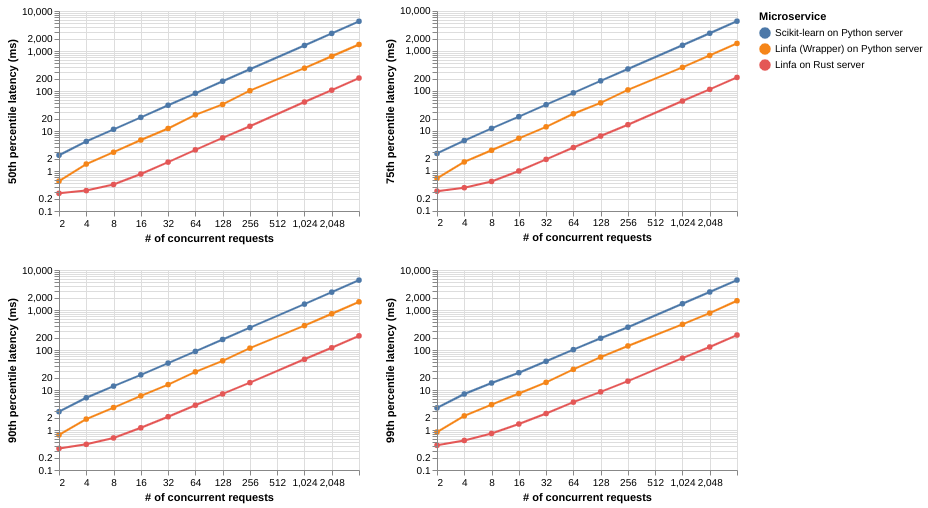

In [11]:
charts = []
for p in [50, 75, 90, 99]:
    chart = alt.Chart(df).mark_line(point=True).encode(
        alt.X('concurrency', scale=alt.Scale(type="log", base=2), title="# of concurrent requests"),
        alt.Y(f'p{p}', scale=alt.Scale(type="log", base=10), title=f"{p}th percentile latency (ms)"),
        color=alt.Color('server', title="Microservice", sort=sorted_names)
    ).properties(
        width=300, height=200
    )
    charts.append(chart)
combined_chart = alt.concat(*charts, columns=2).resolve_scale(y="shared").resolve_axis(x="shared")
combined_chart.save("latencies.svg")
combined_chart

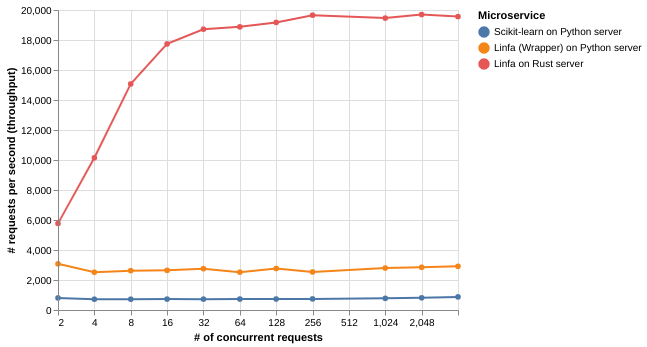

In [12]:
chart = alt.Chart(df).mark_line(point=True).encode(
    alt.X('concurrency', scale=alt.Scale(type="log", base=2), title="# of concurrent requests"),
    alt.Y('requests_per_second', title=f"# requests per second (throughput)"),
    color=alt.Color('server', title="Microservice", sort=sorted_names)
)
chart.save("throughput.svg")
chart

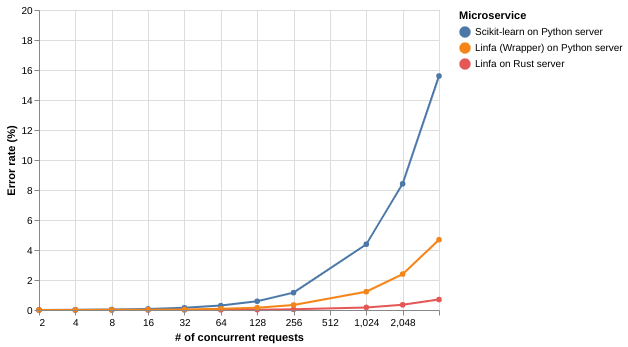

In [13]:
chart = alt.Chart(df).mark_line(point=True).encode(
    alt.X('concurrency', scale=alt.Scale(type="log", base=2), title="# of concurrent requests"),
    alt.Y('error_rate', scale=alt.Scale(domain=[0, 20]), title="Error rate (%)"),
    color=alt.Color('server', title="Microservice", sort=sorted_names)
)
chart.save("error_rate.svg")
chart